# Discussion HW 1
## FINM 25000-2023
### Mark Hendricks

**This is NOT the solution to HW 1.** Rather, it is a notebook used to discuss the homework in class. Thus, it may differ from HW 1 in small ways, and it is not the recommended way to code HW 1.**

**If looking for a solution to emulate, see the `solutions` subfolder in the GitHub repo.**

## Setup

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

## Data

In [2]:
filepath_data = '../data/multi_asset_etf_data.xlsx'
info = pd.read_excel(filepath_data,sheet_name='descriptions')
info.rename(columns={'Unnamed: 0':'Symbol'},inplace=True)
info.set_index('Symbol',inplace=True)

rets = pd.read_excel(filepath_data,sheet_name='total returns')
rets.set_index('Date',inplace=True)
rets.drop(columns=['SHV'])

retsx = pd.read_excel(filepath_data,sheet_name='excess returns')
retsx.set_index('Date',inplace=True)

# sort columns by order of descriptions in Info tab
symbol_list = info.index.drop('SHV')
rets = rets[symbol_list]
retsx = retsx[symbol_list]

In [3]:
info

,ETF Description
Symbol,
SPY,Domestic Equity SPDR S&P500
EFA,Foreign Equity iShares EAFE
EEM,iShares Emerging Markets
PSP,Private Equity Invesco Global Private Equity
QAI,Absolute Return IQ Multi-Strat
HYG,High Yield iShares High Yield Corporate Bond
DBC,Invesco DB Commodity Index Tracking Fund
IYR,Real Estate iShares US Real Estate
IEF,Domestic Bonds iShares 7-10 Year Treasury


In [4]:
retsx

,SPY,EFA,EEM,PSP,QAI,HYG,DBC,IYR,IEF,BWX,TIP
Date,,,,,,,,,,,
2009-04-30,0.0988,0.1146,0.1550,0.2296,0.0223,0.1379,-0.0016,0.2956,-0.0280,0.0084,-0.0185
2009-05-31,0.0589,0.1324,0.1599,0.0544,0.0283,0.0290,0.1631,0.0232,-0.0203,0.0541,0.0204
2009-06-30,-0.0013,-0.0146,-0.0231,0.0448,-0.0040,0.0329,-0.0269,-0.0255,-0.0062,0.0045,0.0014
2009-07-31,0.0746,0.1004,0.1102,0.1433,0.0154,0.0692,0.0186,0.1058,0.0083,0.0313,0.0009
2009-08-31,0.0365,0.0446,-0.0136,0.0330,-0.0046,-0.0174,-0.0408,0.1315,0.0072,0.0072,0.0080
...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31,0.0596,0.0868,0.0880,0.1302,0.0259,0.0334,0.0056,0.0965,0.0325,0.0324,0.0175
2023-02-28,-0.0281,-0.0337,-0.0786,-0.0095,-0.0114,-0.0218,-0.0475,-0.0625,-0.0356,-0.0499,-0.0164
2023-03-31,0.0320,0.0262,0.0271,-0.0540,0.0008,0.0147,-0.0059,-0.0245,0.0321,0.0420,0.0235


# Functions that will be useful
## Basic performance metrics

In [5]:
def performanceMetrics(returns,annualization=1):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean() * annualization
    metrics['Vol'] = returns.std() * np.sqrt(annualization)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annualization)

    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()

    return metrics

## Tangency portfolio

In [6]:
def tangency_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    return pd.DataFrame(weights, index=returns.columns)

# Section 2 - Required Analysis
## 2.1

In [7]:
mets = performanceMetrics(retsx,annualization=12)
mets.sort_values('Sharpe',ascending=False)

,Mean,Vol,Sharpe,Min,Max
SPY,0.1417,0.1481,0.9570,-0.1290,0.1268
HYG,0.0642,0.0898,0.7147,-0.1044,0.1379
IYR,0.1288,0.1882,0.6844,-0.2005,0.2956
PSP,0.1247,0.2261,0.5518,-0.2789,0.2296
EFA,0.0821,0.1665,0.4931,-0.1452,0.1429
TIP,0.0245,0.0517,0.4730,-0.0676,0.0422
QAI,0.0175,0.0509,0.3434,-0.0605,0.0364
EEM,0.0641,0.1968,0.3257,-0.1791,0.1628
IEF,0.0172,0.0626,0.2742,-0.0476,0.0461
DBC,0.0199,0.1788,0.1111,-0.1776,0.1631


## 2.2

MIN Correlation pair is ('IEF', 'DBC')
MAX Correlation pair is ('EFA', 'PSP')


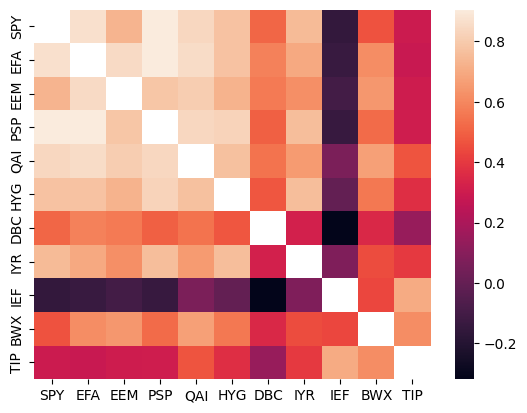

In [8]:
corrmat = retsx.corr()
#ignore self-correlation
corrmat[corrmat==1] = None
sns.heatmap(corrmat)

corr_rank = corrmat.unstack().sort_values().dropna()
pair_max = corr_rank.index[-1]
pair_min = corr_rank.index[0]

print(f'MIN Correlation pair is {pair_min}')
print(f'MAX Correlation pair is {pair_max}')

### TIPS

TIPS have one of the highest Sharpe ratios--they have a low mean, but a very low volatility. Furthermore, they have outperformed Domestic bonds in terms of mean and in terms of volatility.

Notably, TIPS have very low correlation to the other assets--including relatively low correlation to IEF (Domestic Bonds). In the correlation heat map above, we see that TIPS provide a great deal of diversification to all assets except IEF, to which they still provide some diversification.

## 2.3 The Tangency and the MV Frontier

In [9]:
wts = pd.DataFrame(index=retsx.columns)
wts['tangency'] = tangency_weights(retsx)
retsx_tan = pd.DataFrame(retsx @ wts['tangency'],columns=['tangency'])

performanceMetrics(pd.concat([retsx,retsx_tan],axis=1),annualization=12)

,Mean,Vol,Sharpe,Min,Max
SPY,0.1417,0.1481,0.9570,-0.1290,0.1268
EFA,0.0821,0.1665,0.4931,-0.1452,0.1429
EEM,0.0641,0.1968,0.3257,-0.1791,0.1628
PSP,0.1247,0.2261,0.5518,-0.2789,0.2296
QAI,0.0175,0.0509,0.3434,-0.0605,0.0364
HYG,0.0642,0.0898,0.7147,-0.1044,0.1379
DBC,0.0199,0.1788,0.1111,-0.1776,0.1631
IYR,0.1288,0.1882,0.6844,-0.2005,0.2956
IEF,0.0172,0.0626,0.2742,-0.0476,0.0461
BWX,-0.0002,0.0836,-0.0022,-0.0694,0.0780


## Not Required - For Illustration

/Users/markhendricks/Projects/finm-quant-2023/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1256: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


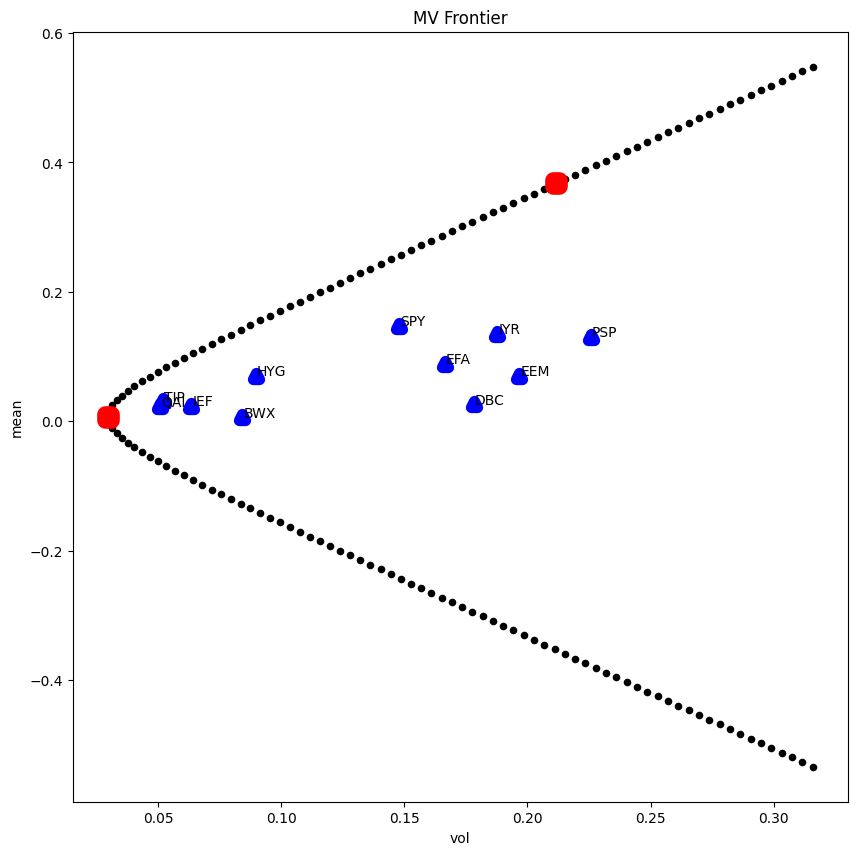

In [10]:
omega_tan = tangency_weights(rets)
rets_adj = rets - rets.mean() + 1
omega_gmv = tangency_weights(rets_adj)
omega = pd.concat([omega_tan,omega_gmv],axis=1)
omega.columns = ['tangency','gmv']

delta_grid = np.linspace(-1.5,1.5,150)
mv_frame = pd.DataFrame(columns=['mean','vol'],index=delta_grid)
for i, delta in enumerate(delta_grid):
    omega_mv = delta * omega_tan + (1-delta) * omega_gmv
    rets_p = rets @ omega_mv
    mv_frame['mean'].iloc[i] = rets_p.mean().values[0] * 12
    mv_frame['vol'].iloc[i] = rets_p.std().values[0] * np.sqrt(12)
    
rets_special = pd.DataFrame(index=rets.index)
rets_special['tan'] = rets @ omega_tan.values
rets_special['gmv'] = rets @ omega_gmv.values

mv_assets = pd.concat([rets.mean() * 12,rets.std() * np.sqrt(12)],axis=1)
mv_special = pd.concat([rets_special.mean() * 12, rets_special.std() * np.sqrt(12)],axis=1)
mv_assets.columns = ['mean','vol']
mv_special.columns = ['mean','vol']

ax = mv_frame.plot.scatter(x='vol',y='mean', c='k', figsize=(10,10), title='MV Frontier')
mv_assets.plot.scatter(x='vol',y='mean',ax=ax, c='b', marker='^', linewidth=8)
mv_special.plot.scatter(x='vol',y='mean',ax=ax, c='r', marker='s', linewidth=12)

for i in range(mv_assets.shape[0]):
    plt.text(x=mv_assets['vol'][i]+.0005, y=mv_assets['mean'][i]+.0005, s=mv_assets.index[i])

### How similar are tangency to 0 (in total returns) and tangency to risk-free (excess returns)?

In [11]:
comp = pd.concat([wts['tangency'], omega['tangency']],axis=1)
comp.columns = ['tan.riskfree','tan.zero']
comp

print(f'Correlation between tangency weights in total and excess returns is {comp.corr().values[0,1]:.4f}.')

Correlation between tangency weights in total and excess returns is 0.9935.


## 2.4 The Allocation

In [27]:
target_mean = .0075

mu_tan = retsx.mean() @ wts['tangency']
delta = target_mean / mu_tan

wts['optimal'] = wts['tangency'] * delta

# list the assets sharpe ratios in a column to demonstrate not highly correlated with optimal weights
comp = pd.concat([wts[['optimal']],mets['Sharpe']],axis=1)
corr_sharpe_wts = comp.corr().values[0][1]

comp.sort_values('optimal',ascending=False)

,optimal,Sharpe
SPY,0.6892,0.9570
IEF,0.6607,0.2742
HYG,0.3521,0.7147
EEM,0.0908,0.3257
TIP,0.0793,0.4730
EFA,0.0536,0.4931
DBC,0.0200,0.1111
IYR,-0.1071,0.6844
PSP,-0.1488,0.5518
BWX,-0.4103,-0.0022


In [28]:
print(f'Total share in risky assets is {delta:.4f}.\nTotal share in risk-free asset is {1-delta:.4f}')
print(f'Correlation between an assets Sharpe ratio and its weight is {corr_sharpe_wts:.4f}.')

Total share in risky assets is 0.0251.
Total share in risk-free asset is 0.9749
Correlation between an assets Sharpe ratio and its weight is 0.4005.


## 2.5 Simple Portfolios

In [29]:
wts['equal'] = 1/len(retsx.columns)
wts['parity'] = 1/retsx.std()
# rescale these to hit the target mean
wts[['equal','parity']] *= target_mean / (retsx.mean()@wts[['equal','parity']])

wts

,tangency,optimal,equal,parity
SPY,27.4196,0.6892,0.1315,0.1234
EFA,2.1326,0.0536,0.1315,0.1097
EEM,3.6111,0.0908,0.1315,0.0929
PSP,-5.9211,-0.1488,0.1315,0.0808
QAI,-49.8963,-1.2542,0.1315,0.3591
HYG,14.0073,0.3521,0.1315,0.2033
DBC,0.7950,0.0200,0.1315,0.1022
IYR,-4.2629,-0.1071,0.1315,0.0971
IEF,26.2840,0.6607,0.1315,0.2917
BWX,-16.3250,-0.4103,0.1315,0.2185


In [30]:
mets_full = performanceMetrics(retsx @ wts,annualization=12)
mets_full

,Mean,Vol,Sharpe,Min,Max
tangency,3.5806,2.0821,1.7197,-1.4076,2.1629
optimal,0.0900,0.0523,1.7197,-0.0354,0.0544
equal,0.0900,0.1505,0.5980,-0.1694,0.1334
parity,0.0900,0.1492,0.6031,-0.1571,0.1095


## For Illustration, not Required

### Suppose TIPS had a mean return 1% (annualized) higher than in the sample

* Would the weights change much?
* Would the MV frontier change much?

In [31]:
retsx_adj = retsx.copy()
retsx_adj['TIP'] += .01/12

wts_adj = wts[['tangency','optimal']].copy()
wts_adj['tangency adj'] = tangency_weights(retsx_adj)
retsx_tan_adj = pd.DataFrame(retsx_adj @ wts_adj['tangency adj'],columns=['tangency adj'])

mu_adj = retsx_adj.mean()
mu_tan_adj = mu_adj @ wts_adj['tangency adj']
delta_adj = target_mean / mu_tan

wts_adj['optimal adj'] = wts_adj['tangency adj'] * delta_adj

wts_adj

,tangency,optimal,tangency adj,optimal adj
SPY,27.4196,0.6892,9.2197,0.2317
EFA,2.1326,0.0536,1.2914,0.0325
EEM,3.6111,0.0908,1.1816,0.0297
PSP,-5.9211,-0.1488,-2.3302,-0.0586
QAI,-49.8963,-1.2542,-18.0918,-0.4547
HYG,14.0073,0.3521,5.0028,0.1257
DBC,0.7950,0.0200,-0.1271,-0.0032
IYR,-4.2629,-0.1071,-1.6103,-0.0405
IEF,26.2840,0.6607,5.5966,0.1407
BWX,-16.3250,-0.4103,-5.9816,-0.1503


In [17]:
mets_adj = performanceMetrics(retsx_adj @ wts_adj[['tangency adj','optimal adj']], annualization=12)
pd.concat([mets_full.loc[['tangency','optimal']],mets_adj])

,Mean,Vol,Sharpe,Min,Max
tangency,3.5806,2.0821,1.7197,-1.4076,2.1629
optimal,0.1200,0.0698,1.7197,-0.0472,0.0725
tangency adj,1.3265,0.7479,1.7737,-0.4608,0.8557
optimal adj,0.0445,0.0251,1.7737,-0.0154,0.0287


In [18]:
tips_se = retsx['TIP'].std()/np.sqrt(retsx.shape[0])
print(f'Standard error of mean of TIPS is equal to {tips_se:0.4f}')
print(f'Proposed adjustment to mean of TIPS is {.01/12 : 0.4f}')

Standard error of mean of TIPS is equal to 0.0011
Proposed adjustment to mean of TIPS is  0.0008


## 2.6 Out-of-Sample Testing

In [19]:
retsx_IS = retsx.loc[:'2020']
retsx_OOS = retsx.loc['2021':]
wts_IS = tangency_weights(retsx.loc[:'2020'])
wts_IS.columns = ['mv']

wts_IS['equal'] = 1/len(retsx_IS.columns)
wts_IS['parity'] = 1/retsx_IS.std()
# rescale these to hit the target mean
wts_IS *= target_mean / (retsx_IS.mean()@ wts_IS)

wts_IS

,mv,equal,parity
SPY,0.7854,0.1397,0.1215
EFA,-0.0762,0.1397,0.1043
EEM,0.0271,0.1397,0.0860
PSP,-0.0248,0.1397,0.0791
QAI,-1.1978,0.1397,0.3516
HYG,0.4614,0.1397,0.1953
DBC,-0.0708,0.1397,0.0972
IYR,-0.2090,0.1397,0.0940
IEF,0.8448,0.1397,0.3024
BWX,-0.0390,0.1397,0.2304


In [20]:
port_IS = retsx_IS @ wts_IS

performanceMetrics(port_IS,annualization=12)

,Mean,Vol,Sharpe,Min,Max
mv,0.1200,0.0524,2.2898,-0.0187,0.0654
equal,0.1200,0.1545,0.7769,-0.1800,0.1417
parity,0.1200,0.1345,0.8922,-0.1524,0.1043


In [21]:
port_OOS = retsx_OOS @ wts_IS

performanceMetrics(port_OOS,annualization=12)

,Mean,Vol,Sharpe,Min,Max
mv,0.0027,0.1212,0.0226,-0.0711,0.0830
equal,-0.0227,0.1836,-0.1236,-0.1261,0.0973
parity,-0.0656,0.1916,-0.3423,-0.1375,0.0998


### Why does the MV Portfolio do worse?
#### It has a huge position in SPY, and SPY was the best performing asset in 2021!

In [22]:
performanceMetrics(retsx_OOS,annualization=12).sort_values('Sharpe',ascending=False)

,Mean,Vol,Sharpe,Min,Max
DBC,0.1811,0.1816,0.9973,-0.0871,0.1014
SPY,0.0668,0.1764,0.3788,-0.0927,0.0912
EFA,0.0197,0.1743,0.1129,-0.0925,0.1283
IYR,0.0149,0.2109,0.0707,-0.1274,0.0965
PSP,-0.0461,0.2604,-0.1770,-0.1466,0.1302
HYG,-0.0269,0.0945,-0.2849,-0.0697,0.0661
TIP,-0.0299,0.0747,-0.3998,-0.0676,0.0422
EEM,-0.0992,0.1734,-0.5720,-0.1157,0.1525
QAI,-0.0365,0.0575,-0.6354,-0.0401,0.0364
IEF,-0.0775,0.0807,-0.9600,-0.0476,0.0327
